In [108]:
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime
from datetime import datetime

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
import random

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import explained_variance_score, mean_absolute_error
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

'''Algos tslearn and sklearn'''
from tslearn.clustering import KShape, TimeSeriesScalerMeanVariance, TimeSeriesKMeans
from sklearn import svm

'''TensorFlow and Keras'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras.layers import Embedding, Flatten, dot
from keras import regularizers
from keras.losses import mse, binary_crossentropy

'''Dataset analysis'''
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from itertools import chain
from statistics import stdev
from math import sqrt

In [138]:
K.tensorflow_backend._get_available_gpus()
pair = [0,1,2,3,4,5,6,7]
trouble_pair = [0,3,4,7]
anticlock_sequence = [3,2,0,1,4,5,7,6]
clockwise_sequence = [6,7,5,4,1,0,2,3]
location = {5:[0,-1],
            6:[1,0],
            1:[-1,0],
            2:[0,1],
            0:[-1,1],
            3:[1,1],
            4:[-1,-1],
            7:[1,-1]}
resolution = 10

D:\signal_ntd_trackpad
D:\signal_ntd_trackpad


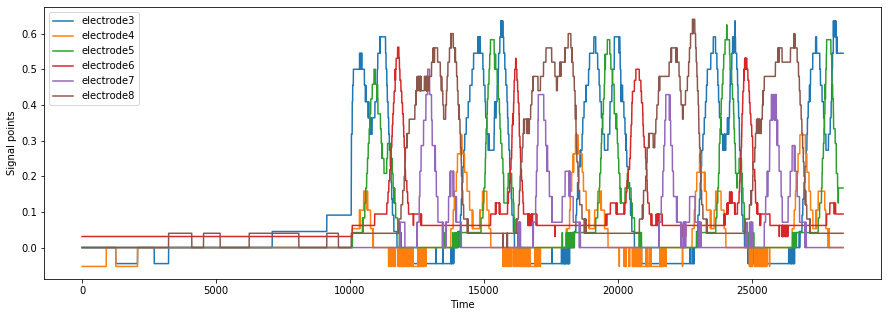

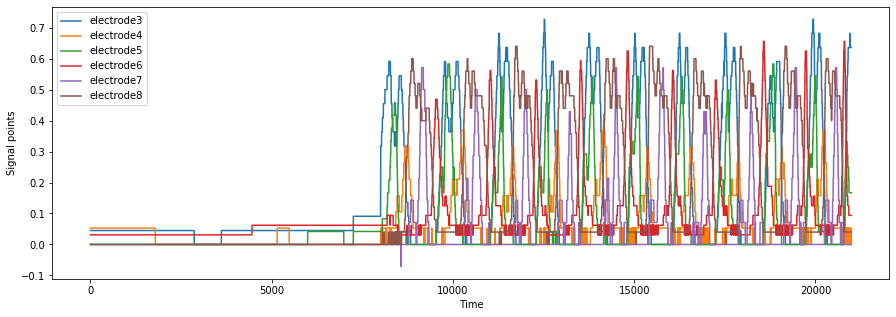

In [5]:
print(os.getcwd())
os.chdir('D:\\signal_ntd_trackpad')
print(os.getcwd())

def get_electrode_data(filename,electrode=pair,adjust=[0]*len(pair)):
    electrodes_points = pd.read_csv(filename)
    electrodes_points.columns = electrodes_points.columns.astype(float)
    electrodes_points.columns = electrodes_points.columns.astype(int)
    for i in range(len(electrode)):
        electrodes_points.loc[:,electrode[i]] = electrodes_points.loc[:,electrode[i]] + adjust[i]
    return electrodes_points.loc[:,pair]

def plot_electrode_data(electrodes_points):
    plt.figure(figsize= (15,5))
    for electrode in electrodes_points.columns:
        plt.plot(electrodes_points.index,electrodes_points.loc[:,electrode],label='electrode' + str(electrode))
    plt.xlabel('Time')
    plt.ylabel('Signal points')
    plt.legend()

data = get_electrode_data('circle_v5.1_clockwise1.csv')
plot_electrode_data(data)
# plt.xlim([6000,7000])

data = get_electrode_data('circle_v5.1_anticlock1.csv')
plot_electrode_data(data)
# plt.xlim([7000,7550])

# decide location based on 9 peaks

In [20]:
print(os.getcwd())
os.chdir('D:\\signal_ntd_trackpad')
print(os.getcwd())
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))


def find_peak(data,height=0.2,distance=350,electrodes=pair,adjusted_height=[0]*len(pair),adjusted_distance=[0]*len(pair)):
    peaks={}
    adjusted_peaks = {}
    for electrode in data.columns:
        new_height = height
        new_distance= distance
        if electrode in electrodes:
            new_height = adjusted_height[electrodes.index(electrode)] + height
            new_distance = adjusted_distance[electrodes.index(electrode)] + distance
        peaks[electrode] = find_peaks(data.loc[:,electrode],height = new_height, distance= new_distance)[0]
        value = data.loc[:,electrode].to_numpy()
        for i,index in enumerate(peaks[electrode]):
            try: 
                segment = value[int(index-distance/5):int(index+distance/5)]
                popt,pcov = curve_fit(gaus,np.linspace(int(index-distance/5),int(index+distance/5-1),
                                                       int(index+distance/5-1) - int(index-distance/5) + 1),
                                      segment,p0=[value[index],index,distance/5])
                peaks[electrode][i] = int(popt[1])
            except:
                continue
            
#     peak_index1 = find_peaks(1000 - data.loc[:,pair[1]],height = height, distance= distance)
#     peak_index2 = find_peaks(1000 - data.loc[:,pair[2]],height = height, distance= distance)
#     peak_index3 = find_peaks(1000 - data.loc[:,pair[3]],height = height, distance= distance)
        print('number of peaks in electrode ', electrode, ' = ',len(peaks[electrode]))
        peaks[electrode].sort()
    return peaks
def plot_peaks(data,peaks):
    for electrode in data.columns:
        plt.plot(data.index[peaks[electrode]],data.loc[peaks[electrode],electrode],'x')
        

def electrode_sequence(sequence):
    elec_sequence=[]
    for i in sequence:
        elec_sequence.append(pair[i])
    return elec_sequence

def rotate(l,n):
    return l[n:] + l[:n]

def arrage_peaks_seq(peaks,elec_sequence):
#     print('inside arrage_peaks_seq',peaks)
    start = min(chain(*peaks.values()))
    while True:
        for key in peaks.keys():
            if start in peaks[key] and key in trouble_pair:
                print('delete ',start,type(peaks[key]),key)
                peaks[key] = peaks[key][1:]
                start = min(chain(*peaks.values()))
            elif start in peaks[key] and key not in trouble_pair:
                start_electrode = key
        try:
            print('start_electrod', start_electrode)
            break
        except:
            continue
        
    while True:
#         print(elec_sequence,start_electrode)
        if elec_sequence[0] == start_electrode:
            break
        else:
            elec_sequence = rotate(elec_sequence,1)
    angle_seq = arrage_angle_seq(elec_sequence)
    i = 0
    final_peak = []
    final_sequence = []
    prev_peak = 0
    while True:
#         print('electrode_sequence',elec_sequence,peaks,elec_sequence[i%len(elec_sequence)])
        cycle = int(i/len(elec_sequence))
        try:
            peak = peaks[elec_sequence[i%len(elec_sequence)]][0]
#             print('peaks ',elec_sequence[i%len(elec_sequence)],' has peaks ', peaks[elec_sequence[i%len(elec_sequence)]])
        except:
            break
        if peak > prev_peak:
#             print('adding peaks',i,peak)
            final_peak.append(peak)
            prev_peak = peak
            peaks[elec_sequence[i%len(elec_sequence)]] = peaks[elec_sequence[i%len(elec_sequence)]][1:]
            final_sequence.append(elec_sequence[i%len(elec_sequence)])
        else:
            print('error in finding peaks',prev_peak,peak)
            break
        i += 1
    return final_peak,final_sequence

def arrage_coord_seq(final_sequence,direction='clockwise'):
    final_coords = []
    for i,elec in enumerate(final_sequence):
        if elec in trouble_pair:
            try: 
                x = location[final_sequence[i-1]][0] + location[final_sequence[i+1]][0]
            except:
                if direction == 'clockwise':
                    x = location[final_sequence[i-1]][0] + location[final_sequence[i-1]][1]
                else:
                    x = location[final_sequence[i-1]][0] - location[final_sequence[i-1]][1]
#             print('The position before and after ',location[final_sequence[i-1]],location[final_sequence[i+1]])
            final_coords.append([x,location[elec][1]])
        else:
            final_coords.append(location[elec])
    return final_coords

def create_training_data_square(data,final_peak,final_coords):
    i = 0
    X_data = data.loc[final_peak[0],:].to_numpy()
    y_data = np.array(final_coords[0])
    for i,index in enumerate(final_peak):
        try:
            len(final_peak) == len(final_coords)
        except:
            print('error in achiving previous data')
        
        try:
            index_difference = (final_peak[i+1] - final_peak[i])/resolution
            y_difference = (np.array(final_coords[i+1]) - np.array(final_coords[i]))/resolution
        except:
            break
        
        X = data.loc[int(index),:].to_numpy()
        y = np.array(final_coords[i]).astype(float)
        for j in range(resolution):
            X_data = np.vstack((X_data,X))
            y_data = np.vstack((y_data,y))
            index += index_difference
            X = data.loc[int(index),:].to_numpy()
            y += y_difference 
    X_data = np.array(X_data)
    y_data = np.array(y_data)
    return X_data,y_data



D:\signal_ntd_trackpad
D:\signal_ntd_trackpad


# decide location based on 4 peaks

In [139]:
print(os.getcwd())
os.chdir('D:\\signal_ntd_trackpad')
print(os.getcwd())
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))


def find_peak(data,height=0.2,distance=350,electrodes=pair,adjusted_height=[0]*len(pair),adjusted_distance=[0]*len(pair)):
    peaks={}
    adjusted_peaks = {}
    for electrode in data.columns:
        new_height = height
        new_distance= distance
        if electrode in electrodes:
            new_height = adjusted_height[electrodes.index(electrode)] + height
            new_distance = adjusted_distance[electrodes.index(electrode)] + distance
        peaks[electrode] = find_peaks(data.loc[:,electrode],height = new_height, distance= new_distance)[0]
        value = data.loc[:,electrode].to_numpy()
        for i,index in enumerate(peaks[electrode]):
            try: 
                segment = value[int(index-distance/5):int(index+distance/4)]
                popt,pcov = curve_fit(gaus,np.linspace(int(index-distance/4),int(index+distance/4-1),
                                                       int(index+distance/4-1) - int(index-distance/4) + 1),
                                      segment,p0=[value[index],index,distance/4])
                peaks[electrode][i] = int(popt[1])
            except:
                continue
            
#     peak_index1 = find_peaks(1000 - data.loc[:,pair[1]],height = height, distance= distance)
#     peak_index2 = find_peaks(1000 - data.loc[:,pair[2]],height = height, distance= distance)
#     peak_index3 = find_peaks(1000 - data.loc[:,pair[3]],height = height, distance= distance)
        print('number of peaks in electrode ', electrode, ' = ',len(peaks[electrode]))
        peaks[electrode].sort()
    return peaks
def plot_peaks(data,peaks):
    for electrode in data.columns:
        plt.plot(data.index[peaks[electrode]],data.loc[peaks[electrode],electrode],'x')
        

def electrode_sequence(sequence):
    elec_sequence=[]
    for i in sequence:
        elec_sequence.append(pair[i])
    return elec_sequence

def rotate(l,n):
    return l[n:] + l[:n]

def arrage_peaks_seq(peaks,elec_sequence):
#     print(peaks)
    for key in trouble_pair:
        del peaks[key]
    print('processed elec_sequence =',elec_sequence)
    start = min(chain(*peaks.values()))
    
    for key in peaks.keys():
        if start in peaks[key]:
            start_electrode = key

    
    while True:
#         print(elec_sequence,start_electrode)
        if elec_sequence[0] == start_electrode:
            break
        else:
            elec_sequence = rotate(elec_sequence,1)
    i = 0
    final_peak = []
    final_sequence = []
    prev_peak = 0
    while True:
#         print('electrode_sequence',elec_sequence,peaks,elec_sequence[i%len(elec_sequence)])
        cycle = int(i/len(elec_sequence))
        try:
            peak = peaks[elec_sequence[i%len(elec_sequence)]][0]
#             print('peaks ',elec_sequence[i%len(elec_sequence)],' has peaks ', peaks[elec_sequence[i%len(elec_sequence)]])
        except:
            break
        if peak > prev_peak:
#             print('adding peaks',i,peak)
            final_peak.append(peak)
            prev_peak = peak
            peaks[elec_sequence[i%len(elec_sequence)]] = peaks[elec_sequence[i%len(elec_sequence)]][1:]
            final_sequence.append(elec_sequence[i%len(elec_sequence)])
        else:
            print('error in finding peaks',prev_peak,peak)
            break
        i += 1
    return final_peak,final_sequence

def arrage_coord_seq(final_sequence,direction='clockwise'):
    final_coords = []
    for i,elec in enumerate(final_sequence):
        final_coords.append(location[final_sequence[i]])
        try: 
            middle = np.array(location[final_sequence[i]]) + np.array(location[final_sequence[i+1]])
            final_coords.append(middle)
        except:
            break
    return final_coords

def create_training_data_square(data,final_peak,final_coords):
    X_data = data.loc[final_peak[0],:].to_numpy()
    y_data = np.array(final_coords[0])
    for i,index in enumerate(final_peak):
        try:
            len(final_peak) * 2 - 1 == len(final_coords)
        except:
            print('error in achiving previous data')
        
        try:
            index_difference = (final_peak[i+1] - final_peak[i])/resolution
            
        except:
            break
        
        X = data.loc[int(index),:].to_numpy()
        y = np.array(final_coords[2*i]).astype(float)
        print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from ',y)
        for j in range(resolution):
#             print('>>>>>>>>>>>>>  ',X,y)
            X_data = np.vstack((X_data,X))
            y_data = np.vstack((y_data,y))
            index += index_difference
            X = data.loc[int(index),:].to_numpy()
#             print('inside training data collection loop: ',i)
            if j < resolution/2:
                try:
                    y_difference = (final_coords[2*i+1] - final_coords[2*i])/resolution*2
                except:
                    break
            else:
                try:
                    y_difference = (final_coords[2*i+2] - final_coords[2*i+1])/resolution*2
                except:
                    break
            y += y_difference 
    X_data = np.array(X_data)
    y_data = np.array(y_data)
    return X_data,y_data



D:\Python_projects\etee_server\etee_driver\models
D:\signal_ntd_trackpad


D:\signal_ntd_trackpad
D:\signal_ntd_trackpad
number of peaks in electrode  3  =  28
number of peaks in electrode  4  =  13
number of peaks in electrode  5  =  14
number of peaks in electrode  6  =  13
number of peaks in electrode  7  =  13
number of peaks in electrode  8  =  26
processed elec_sequence = [5, 6, 7, 4]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [0. 1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [1. 0.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [ 0. -1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [-1.  0.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [0. 1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [1. 0.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [ 0. -1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [-1.  0.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [0. 1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [1. 0.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [ 0. -1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [-1.  0

number of peaks in electrode  3  =  22
number of peaks in electrode  4  =  11
number of peaks in electrode  5  =  10
number of peaks in electrode  6  =  11
number of peaks in electrode  7  =  11
number of peaks in electrode  8  =  22
processed elec_sequence = [4, 7, 6, 5]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [-1.  0.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [ 0. -1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [1. 0.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [0. 1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [-1.  0.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [ 0. -1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [1. 0.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [0. 1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [-1.  0.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [ 0. -1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [1. 0.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [0. 1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start f

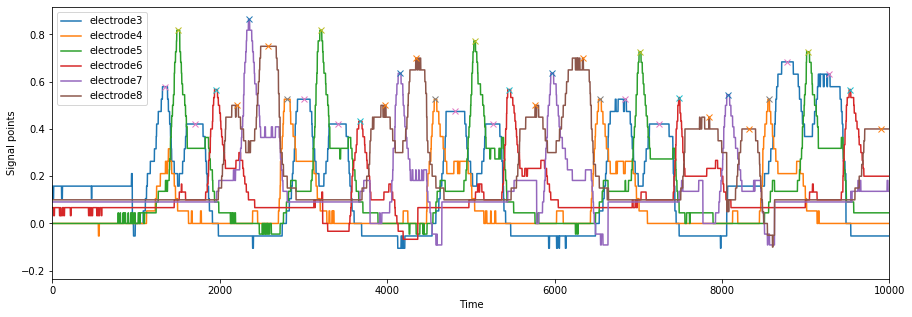

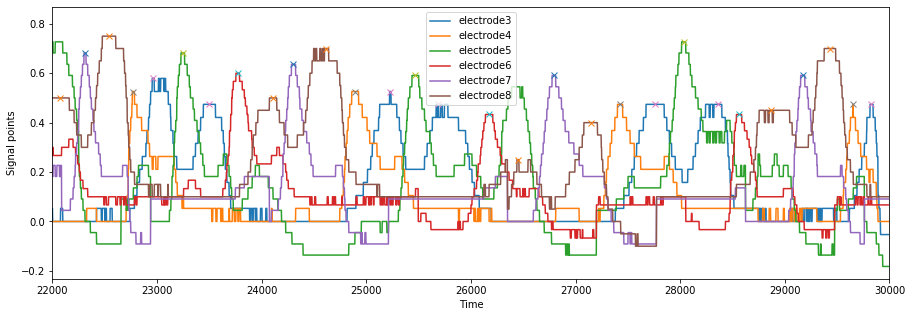

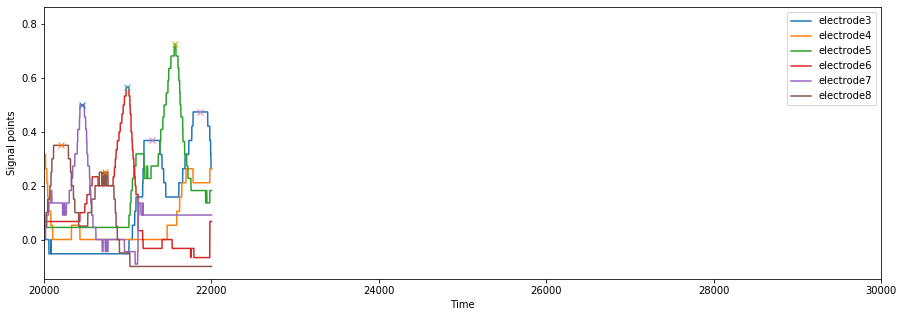

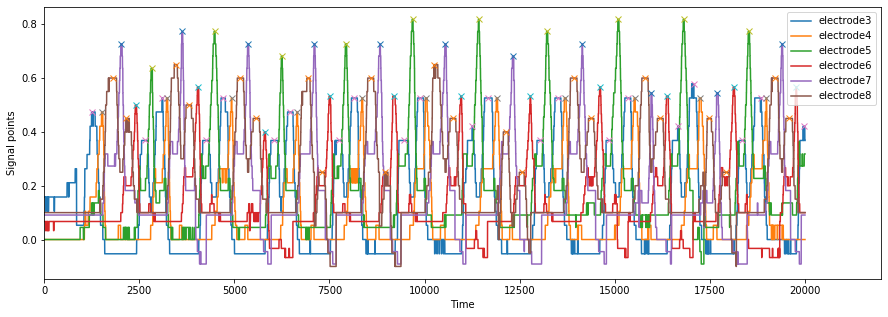

In [86]:
print(os.getcwd())
os.chdir('D:\\signal_ntd_trackpad')
print(os.getcwd())

resolution = 20

data = get_electrode_data('circle_V5_clockwise_1.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data,height =0.40,distance=320,electrodes=[7,3,8],adjusted_height=[0.1,-0.05,-0.15])
plot_electrode_data(data)
plot_peaks(data,peaks)
plt.xlim([00000,10000])
elec_sequence = electrode_sequence(clockwise_sequence)
# print(elec_sequence)
final_peak,final_sequence = arrage_peaks_seq(peaks,elec_sequence)
# print(final_sequence)
final_coords = arrage_coord_seq(final_sequence,direction='clockwise')
# print(final_coords)
X1,y1  = create_training_data_square(data,final_peak,final_coords)
# print(np.hstack((X1,y1)))






data = get_electrode_data('circle_V5_clockwise_2.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data,height =0.40,distance=300,electrodes=[5,8],adjusted_height=[0,-0.2],adjusted_distance=[800,0])
peaks[5][7] = 14850
peaks[5][10] = 21250
# print(peaks)
plot_electrode_data(data)
plot_peaks(data,peaks)
plt.xlim([22000,30000])
elec_sequence = electrode_sequence(clockwise_sequence)
final_peak,final_sequence = arrage_peaks_seq(peaks,elec_sequence)
# print(final_sequence)
final_coords = arrage_coord_seq(final_sequence,direction='clockwise')
# print(final_coords)
X2,y2  = create_training_data_square(data,final_peak,final_coords)
# print(np.hstack((X2,y2)))


data = get_electrode_data('circle_V5_anticlock_1.csv').loc[:22000,:]
# data = np.clip(data,0,804)
peaks = find_peak(data,height =0.40,distance=320,electrodes=[3,8],adjusted_height=[-0.1,-0.2])
plot_electrode_data(data)
plot_peaks(data,peaks)
plt.xlim([20000,30000])
elec_sequence = electrode_sequence(anticlock_sequence)
# print(elec_sequence)
final_peak,final_sequence = arrage_peaks_seq(peaks,elec_sequence)
# print(final_sequence)
final_coords = arrage_coord_seq(final_sequence,direction='anticlock')
# print(final_coords)
X3,y3  = create_training_data_square(data,final_peak,final_coords)
# print(np.hstack((X1,y1)))

data = get_electrode_data('circle_V5_anticlock_2.csv').loc[:20000,:]
# data = np.clip(data,0,804)
peaks = find_peak(data,height =0.40,distance=320,electrodes=[3,8],adjusted_height=[-0.1,-0.2])
plot_electrode_data(data)
plot_peaks(data,peaks)
plt.xlim([00000,22000])
elec_sequence = electrode_sequence(anticlock_sequence)
# print(elec_sequence)
final_peak,final_sequence = arrage_peaks_seq(peaks,elec_sequence)
# print(final_sequence)
final_coords = arrage_coord_seq(final_sequence,direction='anticlock')
# print(final_coords)
X4,y4  = create_training_data_square(data,final_peak,final_coords)
# print(np.hstack((X1,y1)))

D:\signal_ntd_trackpad
D:\signal_ntd_trackpad
number of peaks in electrode  3  =  24
number of peaks in electrode  4  =  11
number of peaks in electrode  5  =  12
number of peaks in electrode  6  =  12
number of peaks in electrode  7  =  11
number of peaks in electrode  8  =  23
elec_sequence [5, 6, 7, 4]
processed elec_sequence = [5, 6, 7, 4]
[5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6]
[[0, 1], array([1, 1]), [1, 0], array([ 1, -1]), [0, -1], array([-1, -1]), [-1, 0], array([-1,  1]), [0, 1], array([1, 1]), [1, 0], array([ 1, -1]), [0, -1], array([-1, -1]), [-1, 0], array([-1,  1]), [0, 1], array([1, 1]), [1, 0], array([ 1, -1]), [0, -1], array([-1, -1]), [-1, 0], array([-1,  1]), [0, 1], array([1, 1]), [1, 0], array([ 1, -1]), [0, -1], array([-1, -1]), [-1, 0], array([-1,  1]), [0, 1], array([1, 1]), [1, 0], array([ 1, -1]), [0, -1], array([-1, -1]), [-1, 0], array([-1,  1]), [0, 1], array(

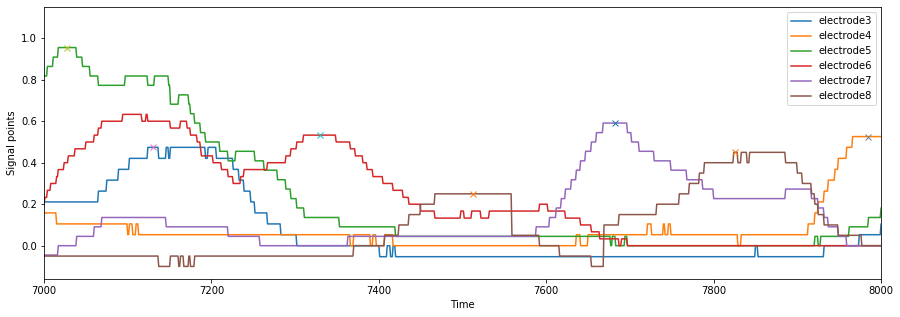

In [87]:
print(os.getcwd())
os.chdir('D:\\signal_ntd_trackpad')
print(os.getcwd())

data = get_electrode_data('circle_V5_clockwise_3.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data,height =0.40,distance=300,electrodes=[3,8],adjusted_height=[-0.1,-0.2],adjusted_distance=[-200,-100])
peaks[6][6] = 7330
plot_electrode_data(data)
plot_peaks(data,peaks)
plt.xlim([7000,8000])
elec_sequence = electrode_sequence(clockwise_sequence)
print('elec_sequence',elec_sequence)
final_peak,final_sequence = arrage_peaks_seq(peaks,elec_sequence)
print(final_sequence)
final_coords = arrage_coord_seq(final_sequence,direction='clockwise')
print(final_coords)
X5,y5  = create_training_data_square(data,final_peak,final_coords)
# print(np.hstack((X2,y2)))

D:\signal_ntd_trackpad
D:\signal_ntd_trackpad


C:\Users\TG0\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  import sys
C:\Users\TG0\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


Train on 131 samples, validate on 131 samples
Epoch 1/50
131/131 [==============================] - 1s 5ms/step - loss: 0.4333 - acc: 0.4733 - val_loss: 0.4232 - val_acc: 0.4733
Epoch 2/50
131/131 [==============================] - 0s 46us/step - loss: 0.4230 - acc: 0.4733 - val_loss: 0.4137 - val_acc: 0.4733
Epoch 3/50
131/131 [==============================] - 0s 46us/step - loss: 0.4138 - acc: 0.4733 - val_loss: 0.4057 - val_acc: 0.4809
Epoch 4/50
131/131 [==============================] - 0s 46us/step - loss: 0.4056 - acc: 0.4809 - val_loss: 0.3989 - val_acc: 0.4809
Epoch 5/50
131/131 [==============================] - 0s 46us/step - loss: 0.3989 - acc: 0.4809 - val_loss: 0.3925 - val_acc: 0.4962
Epoch 6/50
131/131 [==============================] - 0s 38us/step - loss: 0.3923 - acc: 0.4962 - val_loss: 0.3861 - val_acc: 0.4962
Epoch 7/50
131/131 [==============================] - 0s 46us/step - loss: 0.3861 - acc: 0.4962 - val_loss: 0.3797 - val_acc: 0.4962
Epoch 8/50
131/131 [====

No handles with labels found to put in legend.


D:\signal_ntd_trackpad
D:\Python_projects\etee_server\etee_driver\models


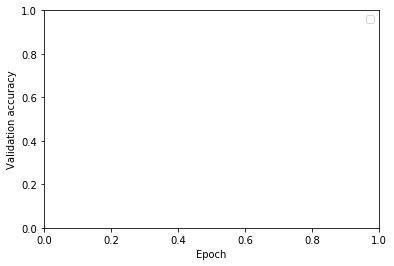

In [93]:
print(os.getcwd())
os.chdir('D:\\signal_ntd_trackpad')
print(os.getcwd())


dataset_num = 5
X_data = np.vstack((eval('X'+str(i)) for i in range(1,dataset_num + 1)))
y_data = np.vstack((eval('y'+str(i)) for i in range(1,dataset_num + 1)))

# X_data = np.round(X_data*100,0).astype(int)
# y_data = np.round(y_data*100,0).astype(int)
np.savetxt(r'D:\\signal_ntd_trackpad\V5_training_data.csv',np.hstack((X_data,y_data)),delimiter=",")
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.133, random_state=2018)

model = Sequential()
model.add(Dense(units = 10,activation="linear", input_dim=6))
model.add(Dense(8, activation="linear"))
model.add(Dense(8, activation="relu"))
model.add(Dense(2, activation="linear"))
model.compile(optimizer='adam',loss = 'mean_squared_error',metrics=['accuracy'])

num_epochs = 50
batch_size = 128
history = model.fit(x = X_train,y = y_train, epochs=num_epochs, batch_size=batch_size, shuffle=True, validation_data=(X_train, y_train),verbose=1)

# model_acc = plotacc(history,j)

y_pred = model.predict(X_test,verbose=1)
accuracy_score_MAE = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
# plt.plot(j*10, 1 - accuracy,'x',label='accuracy with ' + str(j) + ' datasets')
    
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")
plt.legend()
# plt.ylim([0.8,1])
print(os.getcwd())
os.chdir(r'D:\\Python_projects/etee_server/etee_driver/models/')
print(os.getcwd())

model.save('ntd_v5_trackpad_model.h5')

In [122]:
resolution = 20
def generate_straight_line_trining_data(data,start,end):
    X_data = []
    y_data = []
    start = np.array(start).astype(float)
    end = np.array(end).astype(float)
    data = data.loc[:,:].to_numpy()
    y_difference = (end - start)/resolution
    index_difference = len(data)/resolution
    index = 0
    coords = start
    X_data = data[int(index),:]
    y_data = coords
#     print(X_data,y_data)
    while True:
        index += index_difference
        coords += y_difference
        try:
#             print('add coords',coords)
            if any(abs(x)>1 for x in coords):
                break
            X_data = np.vstack((X_data,data[int(index),:]))
            y_data = np.vstack((y_data,coords))
        except:
            break

    X_data = np.array(X_data)
    y_data = np.array(y_data)
#     print(y_data)
    return X_data,y_data


## analyse straight line

D:\signal_ntd_trackpad
D:\signal_ntd_trackpad


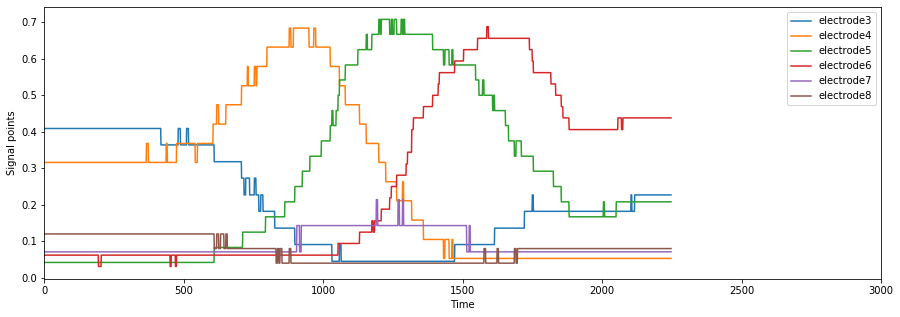

In [123]:
print(os.getcwd())
os.chdir('D:\\signal_ntd_trackpad')
print(os.getcwd())

data = get_electrode_data('circle_v5.2_line2.csv')
plot_electrode_data(data)
plt.xlim([00,3000])
resolution = 30
data = get_electrode_data('circle_v5.2_line1.csv').loc[1900:2600,:]
X1,y1 = generate_straight_line_trining_data(data,[-1,1], [1,1])
data = get_electrode_data('circle_v5.2_line2.csv').loc[550:1900,:]
X2,y2 = generate_straight_line_trining_data(data,[-1,0.5], [1,0.5])

data = get_electrode_data('circle_v5.2_line3.csv').loc[250:1500,:]
X3,y3 = generate_straight_line_trining_data(data,[-1,0], [1,0])

data = get_electrode_data('circle_v5.2_line4.csv').loc[450:1650,:]
X4,y4 = generate_straight_line_trining_data(data,[-1,-0.5], [1,-0.5])
data = get_electrode_data('circle_v5.2_line5.csv').loc[500:1300,:]
X5,y5 = generate_straight_line_trining_data(data,[-1,-1], [1,-1])
data = get_electrode_data('circle_v5.2_line6.csv').loc[270:1200,:]
X6,y6 = generate_straight_line_trining_data(data,[-1,1], [-1,-1])
data = get_electrode_data('circle_v5.2_line7.csv').loc[370:1550,:]
X7,y7 = generate_straight_line_trining_data(data,[-0.5,1], [-0.5,-1])
data = get_electrode_data('circle_v5.2_line8.csv').loc[250:1600,:]
X8,y8 = generate_straight_line_trining_data(data,[0,1], [0,-1])
data = get_electrode_data('circle_v5.2_line9.csv').loc[300:1500,:]
X9,y9 = generate_straight_line_trining_data(data,[0.5,1], [0.5,-1])
data = get_electrode_data('circle_v5.2_line10.csv').loc[300:1300,:]
X10,y10 = generate_straight_line_trining_data(data,[1,1], [1,-1])
# print(X10)
data = get_electrode_data('circle_v5.2_line11.csv').loc[450:2050,:]
X11,y11 = generate_straight_line_trining_data(data,[0,1], [0,-1])
data = get_electrode_data('circle_v5.2_line12.csv').loc[400:1650,:]
X12,y12 = generate_straight_line_trining_data(data,[0,1], [0,-1])
resolution = 80
data = get_electrode_data('circle_v5.2_line13.csv').loc[300:2500,:]
X13,y13 = generate_straight_line_trining_data(data,[-1,1], [1,-1])
data = get_electrode_data('circle_v5.2_line14.csv').loc[450:2250,:]
X14,y14 = generate_straight_line_trining_data(data,[-1,-1], [1,1])
data = get_electrode_data('circle_v5.2_line15.csv').loc[550:2800,:]
X21,y21 = generate_straight_line_trining_data(data,[-1,1], [1,-1])
data = get_electrode_data('circle_v5.2_line16.csv').loc[520:2700,:]
X22,y22 = generate_straight_line_trining_data(data,[-1,-1], [1,1])

## Analyse circle training data

In [142]:
print(os.getcwd())
os.chdir('D:\\signal_ntd_trackpad')
print(os.getcwd())

resolution = 40
# anticlock_sequence = [1,4,3,2]
# clockwise_sequence = [2,3,4,1]
# data = get_electrode_data('circle_v5.1_clockwise1.csv')
# # data = np.clip(data,0,804)
# peaks = find_peak(data,height =0.25,distance=2000)
# print(peaks,peaks[8][-1])
# peaks[8][-1]
# plot_electrode_data(data)
# plot_peaks(data,peaks)
# # plt.xlim([7000,8000])
# elec_sequence = electrode_sequence(clockwise_sequence)
# print('elec_sequence = ',elec_sequence)
# final_peak,final_sequence = arrage_peaks_seq(peaks,elec_sequence)
# print(final_peak)
# final_coords = arrage_coord_seq(final_sequence,direction='clockwise')
# # print(final_coords)
# X15,y15  = create_training_data_square(data,final_peak,final_coords)
# # print(np.hstack((X2,y2)))


data = get_electrode_data('circle_v5.3_anticlock1.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data,height =0.25,distance=1000)
# print(peaks,peaks[8][-1])
plot_electrode_data(data)
plot_peaks(data,peaks)
plt.xlim([11000,15000])
elec_sequence = electrode_sequence(anticlock_sequence)
final_peak,final_sequence = arrage_peaks_seq(peaks,elec_sequence)
print(final_peak)
final_coords = arrage_coord_seq(final_sequence,direction='anticlock')
# print(final_coords)
X16,y16  = create_training_data_square(data,final_peak,final_coords)
# print(np.hstack((X2,y2)))

D:\signal_ntd_trackpad
D:\signal_ntd_trackpad


KeyError: 8

## Plot some training data

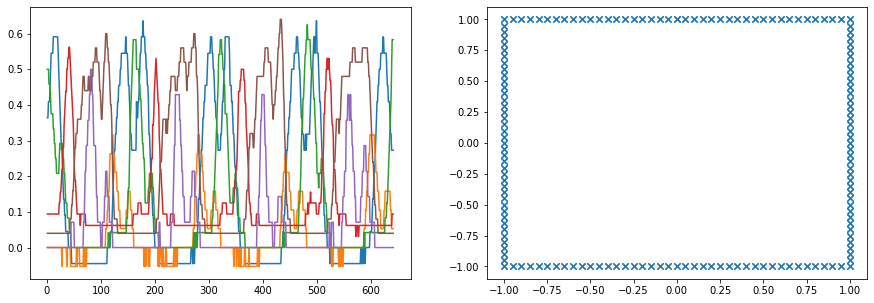

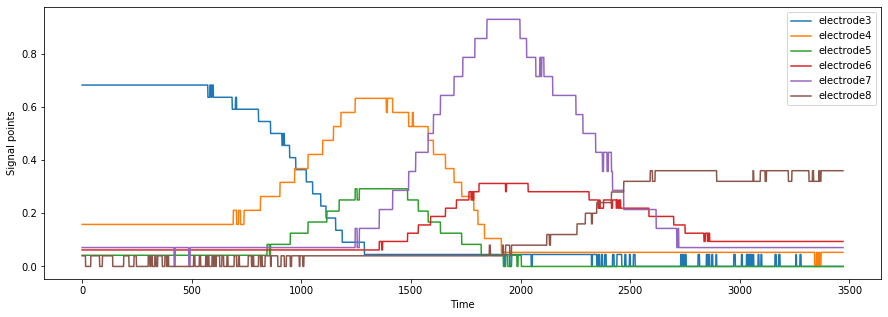

In [125]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

number = 15
Y_axis,coord = eval('X'+str(number)),eval('y'+str(number))
X_axis = np.linspace(1,len(Y_axis),len(Y_axis))

for i in range(Y_axis.shape[1]):
    ax1.plot(X_axis,Y_axis[:,i])

ax2.plot(coord[:,0],coord[:,1],'x')
data = get_electrode_data('circle_v5.2_line'+str(number)+'.csv')
plot_electrode_data(data)

D:\signal_ntd_trackpad
number of peaks in electrode  3  =  9
number of peaks in electrode  4  =  8
number of peaks in electrode  5  =  9
number of peaks in electrode  6  =  8
number of peaks in electrode  7  =  8
number of peaks in electrode  8  =  8
processed elec_sequence = [4, 7, 6, 5]
[12742, 13093, 13584, 13992, 14389, 14737, 15213, 15653, 16057, 16406, 16949, 17378, 17756, 18151, 18615, 19008, 19405, 19724, 20168, 20532, 20891, 21219, 21625, 22006, 22348, 22699, 23116, 23480, 23786, 24113, 24492, 24833, 24885]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [0. 1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [-1.  0.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [ 0. -1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [1. 0.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [0. 1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [-1.  0.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [ 0. -1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [1. 0.]
>>>>>>>>>>>>>>>>>>>>>>

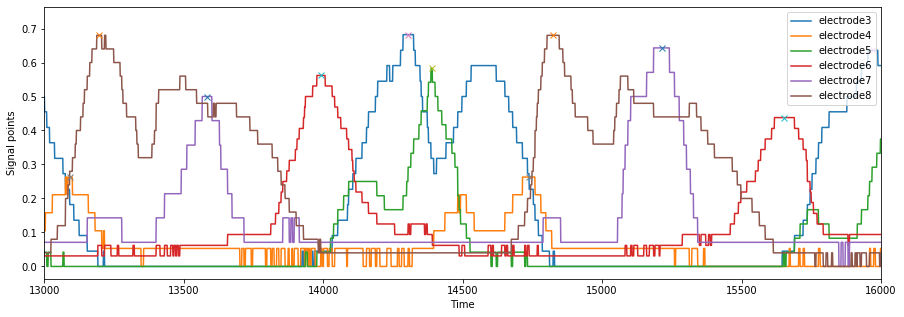

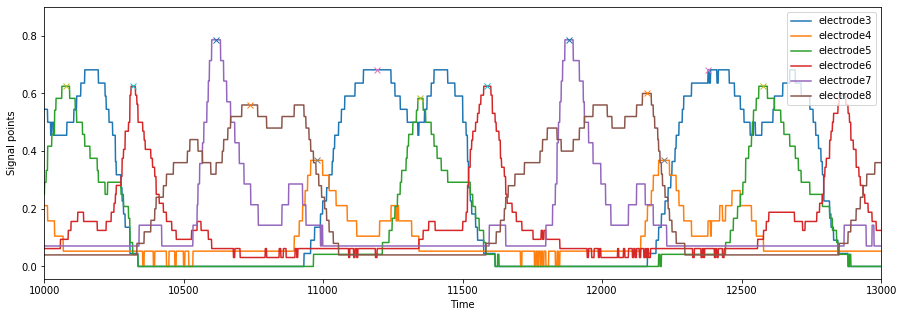

In [126]:
# print(os.getcwd())
os.chdir('D:\\signal_ntd_trackpad')
print(os.getcwd())


data = get_electrode_data('circle_v5.1_anticlock2.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data,height =0.2,distance=1000)
plot_electrode_data(data)
plot_peaks(data,peaks)
plt.xlim([13000,16000])
elec_sequence = electrode_sequence(anticlock_sequence)
final_peak,final_sequence = arrage_peaks_seq(peaks,elec_sequence)
print(final_peak)
final_coords = arrage_coord_seq(final_sequence,direction='anticlock')
# print(final_coords)
X17,y17  = create_training_data_square(data,final_peak,final_coords)
# print(np.hstack((X2,y2)))



data = get_electrode_data('circle_v5.1_clockwise2.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data,height =0.2,distance=1000)
plot_electrode_data(data)
plot_peaks(data,peaks)
plt.xlim([10000,13000])
elec_sequence = electrode_sequence(clockwise_sequence)
final_peak,final_sequence = arrage_peaks_seq(peaks,elec_sequence)
print(final_peak)
final_coords = arrage_coord_seq(final_sequence,direction='clockwise')
# print(final_coords)
X18,y18  = create_training_data_square(data,final_peak,final_coords)
print(np.hstack((X18,y18)).shape)

D:\signal_ntd_trackpad
number of peaks in electrode  3  =  11
number of peaks in electrode  4  =  10
number of peaks in electrode  5  =  11
number of peaks in electrode  6  =  10
number of peaks in electrode  7  =  10
number of peaks in electrode  8  =  10
processed elec_sequence = [5, 6, 7, 4]
[5161, 5477, 5910, 6181, 6473, 6703, 7030, 7278, 7547, 7768, 8036, 8258, 8519, 8737, 9005, 9213, 9440, 9616, 9909, 10110, 10315, 10490, 10743, 10960, 11194, 11393, 11639, 11840, 12047, 12233, 12465, 12679, 12880, 13067, 13325, 13534, 13756, 13796, 14147, 14311, 14479]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [0. 1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [1. 0.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [ 0. -1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [-1.  0.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [0. 1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [1. 0.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>start from  [ 0. -1.]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>s

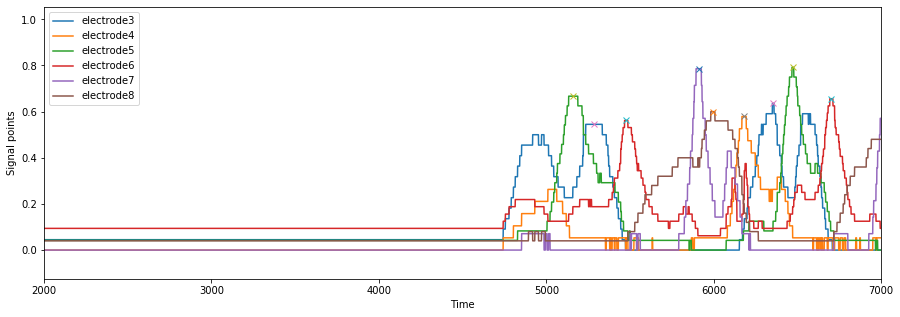

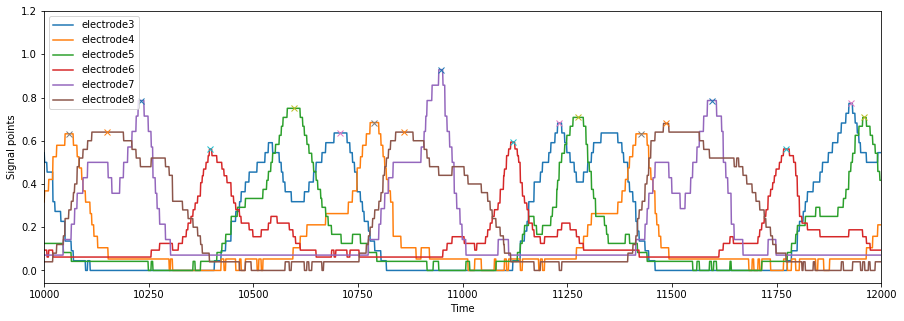

In [127]:
# print(os.getcwd())
os.chdir('D:\\signal_ntd_trackpad')
print(os.getcwd())

data = get_electrode_data('circle_v5.1_clockwise3.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data,height =0.35,distance=700)
plot_electrode_data(data)
plot_peaks(data,peaks)
plt.xlim([2000,7000])
elec_sequence = electrode_sequence(clockwise_sequence)
final_peak,final_sequence = arrage_peaks_seq(peaks,elec_sequence)
print(final_peak)
final_coords = arrage_coord_seq(final_sequence,direction='clockwise')
# print(final_coords)
X19,y19  = create_training_data_square(data,final_peak,final_coords)
print(np.hstack((X2,y2)).shape)

data = get_electrode_data('circle_v5.1_anticlock3.csv')
# data = np.clip(data,0,804)
peaks = find_peak(data,height =0.25,distance=500)
plot_electrode_data(data)
plot_peaks(data,peaks)
plt.xlim([10000,12000])
elec_sequence = electrode_sequence(anticlock_sequence)
final_peak,final_sequence = arrage_peaks_seq(peaks,elec_sequence)
print(final_peak)
final_coords = arrage_coord_seq(final_sequence,direction='anticlock')
# print(final_coords)
X20,y20  = create_training_data_square(data,final_peak,final_coords)
# print(np.hstack((X2,y2)))


In [137]:
dataset_num = 22

X_data = np.vstack((eval('X'+str(i)) for i in range(1,dataset_num + 1)))
y_data = np.vstack((eval('y'+str(i)) for i in range(1,dataset_num + 1)))
print(X_data.shape[1])
# for i in range(len(pair)):
#     print('i = ',i)
#     for j in range(i+1,len(pair)):
#         print('j= ',j)
#         extra_col = np.divide(X_data[:,i],X_data[:,j])
#         extra_col = np.reshape(extra_col,(-1,1))
#         X_data = np.hstack((X_data,extra_col))
            
# X_data = X_data[:,1:5]
# X_data = np.vstack((X_data,X2_data))
# y_data = np.vstack((y_data,y2_data))
np.savetxt(r'D:\\signal_ntd_trackpad\V5_training_data.csv',np.hstack((X_data,y_data)),delimiter=",",fmt='%.3f')

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.33, random_state=2018)

clf1 = svm.SVR()
clf1.fit(X_train,y_train[:,0])
clf2 = svm.SVR()
clf2.fit(X_train,y_train[:,1])

y_pred1 = clf1.predict(X_test)
y_pred2 = clf2.predict(X_test)
y_pred = np.vstack((y_pred1,y_pred2)).T
print(y_pred.shape,y_test.shape)
accuracy_score_MAE = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
print('sklearn svr accuracy  = ', 1 - accuracy_score_MAE)

from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn import linear_model
MOR = MultiOutputRegressor(linear_model.BayesianRidge())
MOR.fit(X_train, y_train)
y_pred = MOR.predict(X_test)
accuracy_score_MAE = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
print('sklearn multiple output regression accuracy  = ', 1 - accuracy_score_MAE)




model = Sequential()
model.add(Dense(units = 10,activation="linear", input_dim=6))
model.add(Dense(8, activation="linear"))
# model.add(Dense(8, activation="relu"))
model.add(Dense(6, activation="linear"))
model.add(Dense(2, activation="linear"))
model.compile(optimizer='adam',loss = 'mean_squared_error',metrics=['accuracy'])

num_epochs = 100
batch_size = 128
history = model.fit(x = X_train,y = y_train, epochs=num_epochs, batch_size=batch_size, shuffle=True, validation_data=(X_test, y_test),verbose=0)

# # model_acc = plotacc(history,j)

y_pred = model.predict(X_test,verbose=1)
accuracy_score_MAE = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
print('keras neural network accuracy  = ', 1 - accuracy_score_MAE)
# # plt.plot(j*10, 1 - accuracy,'x',label='accuracy with ' + str(j) + ' datasets')
    
# plt.xlabel("Epoch")
# plt.ylabel("Validation accuracy")
# plt.legend()
# # plt.ylim([0.8,1])
print(os.getcwd())
os.chdir(r'D:\\Python_projects/etee_server/etee_driver/models/')
print(os.getcwd())

# model.save('ntd_v5_trackpad_model.h5')

with open('ntd_v5_trackpad_model.pkl', 'wb') as fid:
    pickle.dump([clf1,clf2], fid)
    

C:\Users\TG0\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\TG0\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  after removing the cwd from sys.path.
C:\Users\TG0\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


6


C:\Users\TG0\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


(3212, 2) (3212, 2)
sklearn svr accuracy  =  [0.7316224  0.88491386]
sklearn multiple output regression accuracy  =  [0.59582812 0.83933245]
3212/3212 [==============================] - 1s 175us/step
keras neural network accuracy  =  [0.59557884 0.83985991]
D:\signal_ntd_trackpad
D:\Python_projects\etee_server\etee_driver\models


In [136]:
rer.predict(np.array([[0.0, 0.105, 0.091, 0.167, 0.045, 0.55]]))

array([-0.06319518])